In [5]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist
from mpl_toolkits.mplot3d import Axes3D
import soundfile as sf
from prettytable import PrettyTable
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import hilbert, butter, filtfilt, medfilt, lfilter, wiener, convolve

**DICCIONARIOS CON LAS RUTAS**

In [6]:
fruit_types = ['pera', 'banana', 'manzana', 'naranja']
audios = {fruit: [] for fruit in fruit_types}
root_dir = '../../dataset'

for dirname, _, filenames in os.walk(root_dir):
    fruit_type = os.path.basename(dirname)
    if fruit_type in fruit_types:
        audios[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [7]:
processed = {fruit: [] for fruit in fruit_types}

for dirname, _, filenames in os.walk(root_dir):
    path = os.path.basename(dirname)
    if path == 'processed':
        fruit_type = os.path.basename(os.path.dirname(dirname))
        if fruit_type in fruit_types:
            processed[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

**CARACTERISTICAS DEL AUDIO**

In [111]:
FRAME_SIZE = 2048 # In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)

**FUNCIONES**

In [57]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

In [136]:
def time_vector(audio):
    signal, sr, duration = load_audio(audio)
    return np.linspace(0, duration, len(signal))

In [158]:
def rms(signal):
    return librosa.feature.rms(y=signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)

In [59]:
def derivative(signal, duration):
    signal = signal.reshape(-1,)
    dy = np.gradient(signal, np.linspace(0, duration, len(signal)))
    return dy

In [78]:
def normalize(signal):
    peak = np.max(signal)
    signal/=peak
    return signal

In [ ]:
def mean(audio_in):
    signal, sr, _ = load_audio(audio_in)
    frames = librosa.util.frame(signal, frame_length=512, hop_length=256)
    mean= np.mean(frames, axis=0)

# Crear un arreglo de tiempo para la visualización
    tiempo = librosa.times_like(mean, sr=sr, hop_length=256)
    
# Visualizar los valores medios en el tiempo
    plt.figure(figsize=(15, 4))
    #librosa.display.waveshow(signal, sr=sr, alpha=0.5)
    plt.plot(tiempo, mean, color='r', linewidth=2)
    plt.title('Señal de Audio y Valor Medio por Frame')
    plt.show()

In [ ]:
def med_filter(audio_in, audio_out, window = 3):
    signal, sr, _ = load_audio(audio_in)
    filtered = medfilt(signal, kernel_size=window)
    sf.write(audio_out, filtered, sr)

In [ ]:
def low_pass_filter(audio_in, audio_out, cutoff_frequency = 5000):
    signal, sr, _ = load_audio(audio_in)
    nyquist = 0.5 * sr
    cutoff = cutoff_frequency / nyquist
    b, a = butter(N=6, Wn=cutoff, btype='low', analog=False, output='ba')
    
    filtered = lfilter(b, a, signal)
    sf.write(audio_out, filtered, sr)

In [ ]:
def exponential_filter(audio_in, audio_out, alpha = 0.1):
    signal, sr, _ = load_audio(audio_in)
    filtered  = lfilter([1 - alpha], [1, -alpha], signal)
    sf.write(audio_out, filtered, sr)

In [ ]:
def wiener_filter(audio_in, audio_out, noise = 0.9):
    signal, sr, _ = load_audio(audio_in)
    filtered = wiener(signal, noise = noise)
    sf.write(audio_out, filtered, sr)

In [ ]:
def mean_movil_filter(audio_in, audio_out, ventana=3):
    # Definir el kernel de promedio móvil
    kernel = np.ones(ventana) / ventana

    signal, sr, _ = load_audio(audio_in)
    # Aplicar el filtro de promedio móvil
    filtered = convolve(signal, kernel, mode='same')
    
    sf.write(audio_out, filtered, sr)

In [12]:
def smooth_envelope(audio, cutoff_frequency = 10.0):
    signal, sr, duration = load_audio(audio)
    analytic_signal = hilbert(signal)

    # Calcular la envolvente de amplitud
    envelope = np.abs(analytic_signal)

    # Aplicar filtro pasa bajos para suavizar la envolvente
    nyquist = 0.5 * sr
    cutoff = cutoff_frequency / nyquist
    b, a = butter(N=6, Wn=cutoff, btype='low', analog=False, output='ba')
    
    smoothed = filtfilt(b, a, envelope)


    plt.figure(figsize=(12, 8))

    # Visualizar la envolvente de amplitud
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(envelope)) / sr, envelope, alpha=0.5, label='Envolvente Original')
    plt.title('Envolvente de Amplitud Original')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.legend()

    # Visualizar la envolvente suavizada
    print(len(smoothed))
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(smoothed)) / sr, smoothed, label='Envolvente Suavizada', color='orange')
    plt.title('Envolvente de Amplitud Suavizada')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [157]:
def preemphasis(audio_in, audio_out, coef=0.97):
    signal, sr, duration = load_audio(audio_in)
    return np.append(signal[0], signal[1:] - coef * signal[:-1])

In [ ]:
def trim(audio_in, audio_out, umbral = 0.35):
    signal, sr, duration = load_audio(audio_in)
    filtered = preemphasis(audio_in, audio_out, 0.975)
    rms_signal = rms(filtered)

    rms_signal = normalize(rms_signal)
    drms = normalize(derivative(rms_signal, duration))

    drms_vector = np.linspace(0, duration, len(drms))

    left_index = np.argmax(np.abs(drms) > umbral) - 1
    rigth_index = len(drms) - 1 - np.argmax(np.abs(np.flip(drms)) > umbral) + 1

    left_time = drms_vector[left_index]
    rigth_time = drms_vector[rigth_index]

    mask_vector = audio_vector >= left_time

    audio_vector = audio_vector[mask_vector]
    trimed_signal = signal[mask_vector]

    mask_vector = audio_vector <= rigth_time

    audio_vector = audio_vector[mask_vector]
    trimed_signal = trimed_signal[mask_vector]

    sf.write(audio_out, trimed_signal, sr)

**FUNCIONES DE EFECTIVIDAD**

In [ ]:
def get_sphere(vectors):
    center = np.mean(vectors, axis = 0)
    center = center.reshape(1, -1)
    radius = cdist(center, vectors).max()     # Pairwise distance
    return radius, center

In [ ]:
def get_centers(features):
    centers = dict.fromkeys(features.keys())
    for fruit, group in features.items():
        _, center = get_sphere(group)
        centers[fruit] = center
    return centers

In [ ]:
def get_radiuses(features):
    radiuses = dict.fromkeys(features.keys())
    for fruit, group in features.items():
        radius, _ = get_sphere(group)
        radiuses[fruit] = radius
    return radiuses

In [ ]:
def get_overlaps(fruit_features):
    centers = get_centers(fruit_features)
    radiuses = get_radiuses(fruit_features)
    overlaps = dict.fromkeys(fruit_features.keys())
    
    # A dictionary of dictionarys. Keys, the fruit types
    for key in overlaps:
        # Each dictionary in the dictionary
        overlaps[key] = dict.fromkeys(fruit_types)
    
    for i in range(len(fruit_types)):
        for j in range(i + 1, len(fruit_types)):
            distancesAB = cdist(centers[fruit_types[i]], fruit_features[fruit_types[j]])
            distancesBA = cdist(centers[fruit_types[j]], fruit_features[fruit_types[i]])

            mask_distancesAB = distancesAB < radiuses[fruit_types[i]]
            mask_distancesBA = distancesBA < radiuses[fruit_types[j]]

            numberBinA = np.count_nonzero(mask_distancesAB)
            numberAinB = np.count_nonzero(mask_distancesBA)

            overlaps[fruit_types[i]][fruit_types[j]] = numberBinA
            overlaps[fruit_types[j]][fruit_types[i]] = numberAinB
    return overlaps # Each element is the number of vectors of one group in the sphere of another

In [ ]:
def get_components(centers, nc):
    pacum = np.zeros((1, centers[fruit_types[0]].shape[1]))
    pair_components = dict()
    for i in range(len(fruit_types)):
        for j in range(i + 1, len(fruit_types)):
            dif = centers[fruit_types[i]] - centers[fruit_types[j]]
            dist = cdist(centers[fruit_types[i]], centers[fruit_types[j]])
            difp = (dif**2)*100/(dist**2)
            pair_components[f"{fruit_types[i]}-{fruit_types[j]}"]= np.argsort(difp[0])[-nc:]
            pacum += difp
    index_max = np.argsort(pacum[0])[-nc:]
    #return np.sort(index_max)
    return index_max, pair_components

**PRINCIPAL**

**KNN**

In [ ]:
def knn(training, test, k_n):
    X = np.concatenate([v for v in training.values()], axis=0)
    y = np.concatenate([[k] * v.shape[0] for k, v in training.items()])

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Crear clasificador KNN
    knn_classifier = KNeighborsClassifier(n_neighbors = k_n)

    # Entrenar el clasificador
    knn_classifier.fit(X, y)

    # Predecir las etiquetas para los datos de prueba
    predicted_fruit = knn_classifier.predict(test)

    print(f'La fruta predicha para el nuevo audio es: {predicted_fruit[0]}')

**PLOTEO**

In [ ]:
#2d
fig = plt.figure()

colors = dict(zip(fruit_types,['green','yellow','red','orange']))
center_colors  = dict(zip(fruit_types,['blue','brown','black','cyan']))

for fruit, points in features.items():
    plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)

plt.xlabel('Eje X')
plt.ylabel('Eje Y')

plt.show()

In [ ]:
#3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for fruit, points in features.items():
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors[fruit], marker='o', label=fruit)
    #ax.scatter(centers[fruit][:, 0], centers[fruit][:, 1], centers[fruit][:, 2], c=center_colors[fruit], marker='o', label=f"{fruit}-center")

# configure labels
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')
plt.show()

In [60]:
def plot_signal(signal, duration, name):
    time_vector = np.linspace(0, duration, len(signal))
    plt.figure(figsize=(15, 5))
    
    #plot
    #librosa.display.waveshow(signal)
    
    plt.plot(time_vector, signal, linestyle='-')
    
    # extra
    plt.title(f'Señal de Audio {name} - Duración: {duration:.2f} segundos')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.show()

In [61]:
#signal
def plot_audio(audio):
    signal, sr, duration = load_audio(audio)
    plot_signal(signal, duration, os.path.basename(audio))

**Lo primero vamos a ver como funciona la función de recorte y los filtros**

In [ ]:
#trim de los audios
for type in audios:
    for i, _ in enumerate(audios[type]):
        wiener_filter(audios[type][i], processed[type][i], 10)

hemos visto que los filtros no funcionan muy bien.
Al oido puede que algunos se escuche que funcionan bien, pero no hacen en realidad mucho por el ruido que queremos eliminar de unos audios, que es el ruido impulsivo al inicio y al final del audio o ruido constante al principio y al final del audio. El que quiesieramos aminorar o eliminar para luego hacer un recorte limpio del audio

In [ ]:
#comparacion gráficas
for type in audios:
    for i, _ in enumerate(audios[type]):
        plot_signal(audios[type][i])
        plot_signal(processed[type][i])
        
        input()

problemas de ruido en pera6, banana6, banana7(un pico al final), banana8(ruido al inicio), manzana6(ruido al inicio), manzana7 (ruido al inicio), manzana8(ruido al final), naranja8(picos al final)

In [ ]:
for fruit, group in audios.items():
    for audio in group:
        rms_signal, duration = rms(audio)

        rms_signal = normalize(rms_signal)
        drms = normalize(derivative(rms_signal, duration))
        
        plot_audio(audio)
        
        plot_signal(rms_signal.reshape(-1,1), duration, "rms")
        plot_signal(drms, duration, 'drms/dt')
        input()

Probamos que es lo que pasa con la media de la señal de audio calculada por frames.
Como que queda medio feo con la función del librosas

In [ ]:
audio = audios['naranja'][6]
rms_signal, duration = rms(audio)

rms_signal = normalize(rms_signal)
drms = normalize(derivative(rms_signal, duration))

plot_audio(audio)
plot_signal(rms_signal.reshape(-1,1), duration, "rms")
plot_signal(drms, duration, 'drms/dt')

Probamos corte con la envolvente entonces.
Bueno, me di cuenta que también se podría llegar a hacer directamente con el rms el recorte porque da mas o menos la misma forma que da la envolvente sin tanta configuración. Con la RMS pareciera que hay unna buena descripción de la envolvente de la seña y además permite el recorte del ruido por identificación de un cambio importante en la derivada de la rms de la señal. El punto de corte se puede identificar cuando la derivada de la señal de rms deja de ser constante y pasa a tener un cambio importante. 44 es lo que le pusimos a la frecuencia de corte y anduvo copado. Osea dependia enrealidad del hopzise que quedo la mitad de un fram size de 4096

In [ ]:
audio = audios['pera'][6]
plot_audio(audio)
smooth_envelope(audio, cutoff_frequency = 44)

PROBAMOS EL FILTRO DE PREEMPHASIS
El filtro de prehempasis anda rejoya

In [ ]:
audio = audios['naranja'][6]
signal, sr, duration = load_audio(audio)
filtered = preemphasis(signal, 0.975)
#sf.write(processed['naranja'][6], filtered, sr)
plot_signal(normalize(signal), duration, os.path.basename(audio))
plot_signal(normalize(filtered), duration, 'filtered')

Ahora hay que probar el filtro de prehempasis con la derivada para tratar el corte

C:\Users\Juan\AppData\Local\Temp\ipykernel_916\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


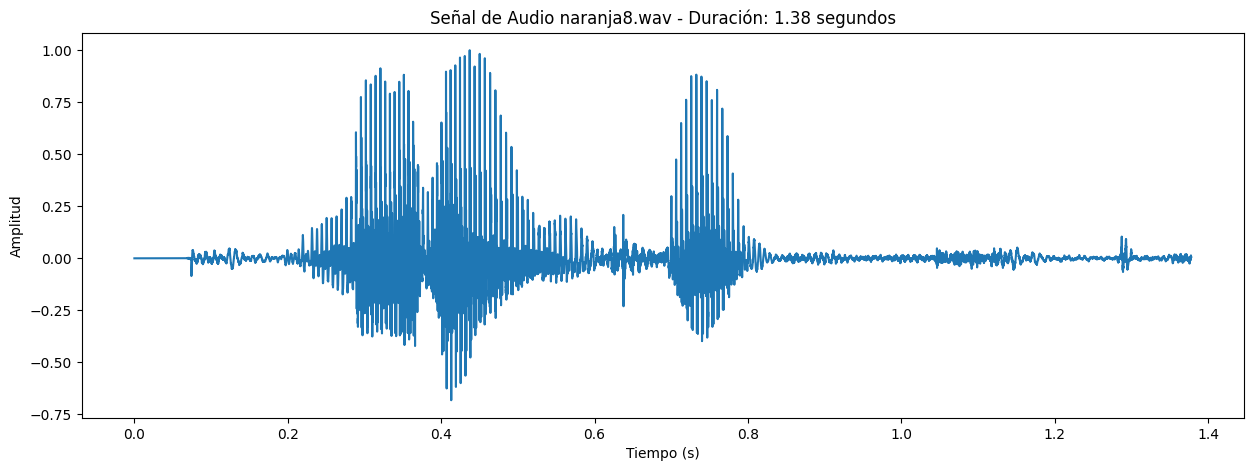

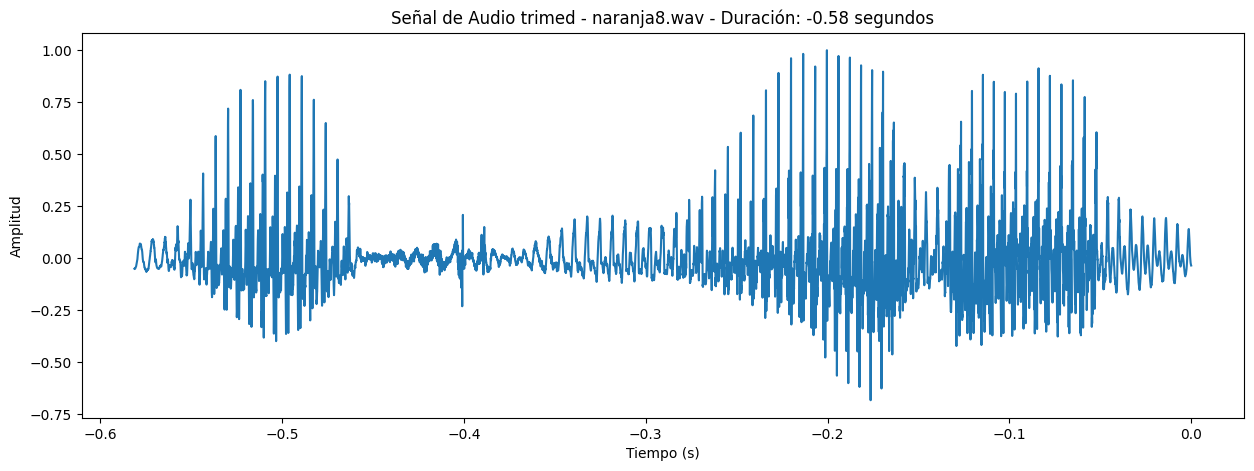

In [156]:
indice = 8
fruit = 'naranja'
umbral = 0.35

audio_in = audios[fruit][indice]
audio_out = processed[fruit][indice]
signal,sr,_ = load_audio(audio_in)

audio_vector = time_vector(audio_in)


filtered = preemphasis(audio_in, audio_out, 0.975)
rms_signal, duration = rms(audio_out)

rms_signal = normalize(rms_signal)
drms = normalize(derivative(rms_signal, duration))

drms_vector = np.linspace(0, duration, len(drms))


left_index = np.argmax(np.abs(drms) > umbral) - 1
rigth_index = len(drms) - 1 - np.argmax(np.abs(np.flip(drms)) > umbral) + 1

left_time = drms_vector[left_index]
rigth_time = drms_vector[rigth_index]


mask_vector = audio_vector >= left_time
audio_vector = audio_vector[mask_vector]

trimed_signal = signal[mask_vector]

mask_vector = audio_vector <= rigth_time
audio_vector = audio_vector[mask_vector]
trimed_signal = trimed_signal[mask_vector]

sf.write(audio_out,trimed_signal,sr)
# Seleccionar la porción de la señal entre los índices encontrados
#trimed = drms[left_index:rigth_index + 1]


plot_audio(audio_in)
#plot_signal(rms_signal.reshape(-1,1), duration, "rms")
#plot_signal(drms, duration, 'drms/dt')
#plot_signal(trimed, left_time-rigth_time, 'trimed')
plot_signal(trimed_signal, left_time-rigth_time, f"trimed - {os.path.basename(audio_in)}")